# Extract medical terms from free text with Spark NLP Healthcare

This notebook was modified from the original one from JSL.

It extracts all the medical terms such as diagnosis, procedure, lab, medications, etc. from free text while using an impressive, state of the art NLP tool: ***Spark NLP for Healthcare*** from https://www.johnsnowlabs.com/.


# Plan:
The performance of the extraction algorithm will be measured with F1 score, the harmonic mean of precision and recall based on the good old confusion matrix (TP, TN, FP, FN). 

F1 will be calculated for each major group: diagnosis, procedure, labs, meds, etc.

* Many thanks to Jiri and David from JS labs for their help and support.



# Import license keys

While Spark-NLP is available for free, the Healthcare version is **not** (except for a one month free trial).

You'll need to purchase a Spark NLP for Healthcare license from JS labs, once you decide to use it for your purposes.

Because it depends on a license, ***this notebook will not run if you fork it***, unless you bring your own license keys...

In [1]:
import os
import json

#license_keys['SECRET'] = 'your secret'
#license_keys['SPARK_NLP_LICENSE'] = 'your nlp_license'
#license_keys['AWS_ACCESS_KEY_ID'] = 'your_aws_key'
#license_keys['AWS_SECRET_ACCESS_KEY'] = 'your_aws_secret'

from kaggle_secrets import UserSecretsClient

license_keys = {}
license_keys.keys()

license_keys["PUBLIC_VERSION"] = '2.6.5'
license_keys["JSL_VERSION"] = '2.7.2'

user_secrets = UserSecretsClient()
os.environ['AWS_ACCESS_KEY_ID'] = user_secrets.get_secret("aws_id")
os.environ['AWS_SECRET_ACCESS_KEY'] = user_secrets.get_secret("aws_secret")
secret = user_secrets.get_secret("license_key_secret")
os.environ['SPARK_NLP_LICENSE'] = user_secrets.get_secret("spark_nlp_license")

sparknlp_version = license_keys["PUBLIC_VERSION"]
jsl_version = license_keys["JSL_VERSION"]

print ('SparkNLP Version:', sparknlp_version)
print ('SparkNLP-JSL Version:', jsl_version)

SparkNLP Version: 2.6.5
SparkNLP-JSL Version: 2.7.2


Install dependencies

In [2]:
# Install Java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==$sparknlp_version
! python -m pip install --upgrade spark-nlp-jsl==$jsl_version --extra-index-url https://pypi.johnsnowlabs.com/$secret

debconf: delaying package configuration, since apt-utils is not installed
openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 130 kB 4.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.johnsnowlabs.com/2.7.2-7ad44c2a1a61c48b6a74446b0a7cb6b97c58dba0
     |████████████████████████████████| 45 kB 442 kB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


Import dependencies into Python and start the Spark session

In [3]:
!ls '/usr/lib/jvm/java-8-openjdk-amd64'

ASSEMBLY_EXCEPTION  bin   include  lib	src.zip
THIRD_PARTY_README  docs  jre	   man


In [4]:
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ['PATH'] = os.environ['JAVA_HOME'] + "/bin:" + os.environ['PATH']

import pandas as pd
import numpy as np
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import sparknlp
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Select the NER model and construct the pipeline

Select the NER model: **ner_diseases, ner_clinical, ner_jsl**

For more details: https://github.com/JohnSnowLabs/spark-nlp-models#pretrained-models---spark-nlp-for-healthcare

In [5]:
# You can change this to the model you want to use and re-run cells below.
# Diagnosis & Procedures models: ner_diseases, ner_clinical, ner_jsl

#MODEL_NAME = "ner_diseases"
#MODEL_NAME = 'ner_clinical'
MODEL_NAME = 'ner_jsl'

In [6]:
#Create the pipeline

document_assembler = DocumentAssembler() \
    .setInputCol('text')\
    .setOutputCol('document')

sentence_detector = SentenceDetector() \
    .setInputCols(['document'])\
    .setOutputCol('sentence')

tokenizer = Tokenizer()\
    .setInputCols(['sentence']) \
    .setOutputCol('token')

word_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token']) \
    .setOutputCol('embeddings')

clinical_ner = NerDLModel.pretrained(MODEL_NAME, 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_converter = NerConverter()\
    .setInputCols(['sentence', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

nlp_pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter])

empty_df = spark.createDataFrame([['']]).toDF("text")
pipeline_model = nlp_pipeline.fit(empty_df)
light_pipeline = LightPipeline(pipeline_model)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14 MB
[OK!]


# Create example input

In [7]:
# Free Text 
input_list = [
    """
    This is an 86-year-old female with a past medical History of asthma, Chf, anemia,
hypertension, Aortic stenosis, myelodysplastic syndrome, chronic kidney disease, gerd, GAVE, right
pleural effusion as well as C. diff colitis. She presented from home with greater than one
month history of Dyspnea, Wheezing and productive cough with blood-tinged Sputum. She was positive
for influenza b, admitted for Acute bronchitis and influenza. After treatment with Tamiflu, Ceftin and IV
Steroid, she continues to have right rib pain, difficulty expectorating and intermittent Wheezing. Repeat
chest x-ray reveals small right lower lobe infiltrate, question of viral etiology, possible aspiration and/or
superimposed infection. Chest x-ray also reveals a right Rib fracture which may be contributing to her
symptoms. Her Dyspnea is most likely secondary to asthmatic bronchitis, influenza and probable Splinting
in the setting of right Rib fracture.
• Popular language: Double vision and potentially a Heart attack
• Acronyms: Bph, CVA, MI, HTN, Niddm, Dvt, Chf, Copd, C-section
• 45 minutes office visit.
• extracapsular cataract removal
• Felty’s syndrome
• Parkinson’s disease
• Crohn’s disease
• Bartholin’s gland Excision
• Meniere’s disease
• lipid panel
• Bil. Testosterone.
• left iliac bypass
• clostridium difficile enterocolitis.
• Lt. Knee Replacement on July 12, 2009
• bilateral knee replacement
• Rt. Hip replacement on May 12, 2012
• guttate psoriasis
• Patient is asthmatic. asthma can be a serious disease…and then asthmatic appears again
1. acute appendicitis and Laparoscopic Appendectomy
2. s/p Laparoscopic Cholecystectomy 1988
3. negative / no finding
4. Arthropathic psoriasis. period. and then same line Psoriatic arthritis
5. diabetes mellitus
6. chronic atrial fibrillation with short periods of Atrial flutter
7. Mild Pulmonary hypertension.
8. Pt underwent rt. eye Trabeculectomy in 1999 (suffering from bil. Glaucoma )
9. acute on chronic Systolic heart failure


and now some free text:

St. Elsewhere Hospital
123 main st.
NYC, NY 12121
telephone 212.212.2121
CO-Consultation Report
PATIENT NAME: Mary Smith J MED REC NO: 121299338177
DOB: 06/10/1927 PATIENT NO: 876876772
SEX: F ROOM NUMBER: 5-998
date: 04/17/2014
CO-Consultation Report
Page 1 of
CONSULTANT: Agent Good, PA
ATTENDING MD: Great Doc, MD
DICTATED BY: Amy Best, PA
reason for consultation: Copd exacerbation, Influenza b.
HISTORY: This is an 86-year-old female with a past medical History of asthma, congestive heart failure,
anemia, hypertension, Aortic stenosis, myelodysplastic syndrome, chronic kidney disease, gerd, GAVE,
right pleural effusion Status post benign Thoracentesis and C. diff colitis. She is well known to Pulmonary
and critical care Services and was seen as an initial consultation by Dr. Louis Gold, March 2014. The
patient was seen post Pneumonia evaluation. Over the past two months, the patient has been treated for
muscle upper respiratory tract infections with a course of Levaquin and subsequently Z-Pak. She was
given a prednisone taper on March 9. Despite taking two rounds of Antibiotics and prednisone, she has
been very slow to respond. She admits to productive cough with white and blood-tinged Sputum, chest
congestion, hoarseness and right rib pain. She was transferred from Our Lady of Mercy Residence to St.
Elsewhere Hospital for further evaluation of Dyspnea. On admission to St. Elsewhere on April 17, she was noted
to have a temperature of 100 degrees Fahrenheit, normotensive and an oxygen saturation of 88% on
room air. Initial chest x-ray did not reveal focal infiltrate. Influenza screen was positive for influenza b.
She was started on Tamiflu, Ceftin and given IV Steroid. The patient states she is slowing improving;
however, has persistent Dyspnea, difficulty expectorating and rib pain.
PAST MEDICAL HISTORY:
1. asthma.
2. congestive heart failure.
3. iron deficiency anemia.
4. depression.
5. hypertension.
6. Mild Aortic stenosis.
7. hypothyroidism.
8. myelodysplastic syndrome.
9. chronic kidney disease.
10. gait abnormality.
11. dysphagia.
12. gerd.
13. GAVE.
14. Upper GI bleed.
15. C. diff colitis.
16. Status post multiple Blood transfusions.
17. Right Thoracentesis with benign cytology, March 2012.
PAST SURGICAL HISTORY:
1. status post right Total knee replacement and left Hip replacement.
2. hysterectomy.
3. Status post back surgery.
4. cataract surgery.
5. Right carotid endarterectomy.
6. EGD with Cauterization for GAVE, November 2012.
7. temporal artery biopsy, negative for Arteritis.
home medications:
1. Acetaminophen 325 mg one tab po every four hours.
2. Allopurinol 100 mg one tab po every day.
3. Calcium carbonate one tab po twice a day.
4. Citalopram 20 mg one tab po every day.
5. Advair 250/50 one puff inhaled bid.
6. Lasix 20 mg one tab po every day.
7. Guaifenesin 5 mL po every four hours prn cough.
8. Hydrocodone/acetaminophen 5/325 one tab po every night at bedtime.
9. Xopenex 1.25 mg/3 mL solution for nebulization every four hours prn Shortness of breath.
10. Levaquin 500 mg tab po every other day, started on April 16.
11. Synthroid 175 micrograms one tab po every day.
12. Loperamide 2 mg one capsule po every four hours prn Diarrhea.
13. Multivitamin one tab po every day.
14. Pantoprazole 40 mg one tab po bid.
15. Potassium chloride 10 mEq one tab po every day.
16. Prednisone 20 mg three tabs po every day for five days.
17. Syllium 3.4 grams one po every day.
18. Spiriva 18 micrograms one cap inhaled every day.
19. Ursodiol 300 mg one cap po tid.
HOSPITAL MEDICATIONS:
1. Albuterol 2.5 mg nebulizer every four hours.
2. Allopurinol 100 mg po every day.
3. Amlodipine 5 mg po every day.
4. Ceftin 500 mg po bid.
5. Celexa 20 mg one tab po every day.
6. Guaifenesin 600 mg po bid.
7. Heparin 5000 units subcu every eight hours.
8. Hydrocodone 5/325 mg one tab po every night at bedtime.
9. Levothyroxine 175 micrograms po every day.
10. Solu-Medrol 40 mg IV every six hours.
11. Multivitamin one tab po every day.
12. Prilosec 40 mg po bid.
13. Tamiflu 75 mg po bid.
14. Potassium chloride 10 mEq po every day.
15. Spiriva one puff inhaled every day.
Allergies:
1. BETA-BLOCKERS cause Dyspnea.
2. CODEINE, Nausea and Vomiting.
review of systems: SYSTEMIC: No Fevers, Chills, night sweats or lower extremity Edema. She
does admit to Weight gain over the last several months that she attributes to her diet.
HEAD: No Headache or sinus pain.
NECK: No lump or swelling.
EYES: No change in vision.
ENT: No nasal discharge, Epistaxis or Sore throat. Positive for hoarseness, positive for chronic hearing
loss.
CARDIOVASCULAR: No Chest pain or Palpitations.
PULMONARY: positive for a history of Pneumonia, chronic Shortness of breath and productive cough
with white colored Sputum, occasionally blood-tinged. Positive for Wheezing. No history of TB exposure.
GI: No change in appetite. Positive for Heartburn. No Nausea, Vomiting, Diarrhea or Abdominal pain.
positive for a history of C. diff colitis.
GU: No Dysuria or Hematuria.
ENDOCRINE: No history of diabetes or thyroid disease.
HEME: No easy Bruising or recent Bleeding. positive for a history of GI Bleeding secondary to GAVE.
MUSCULOSKELETAL: No Muscle aches or pain.
SKIN: No Rash or Lesions.
PHYSICAL EXAMINATION: VITAL SIGNS: Temperature 36.7, blood Pressure 137/71, pulse 70,
respirations 20, sat of 90% on 2 liters Nasal cannula.
GENERAL: This is a very pleasant, well-developed, well-nourished elderly female who is seated in bed in
no acute Respiratory distress. She he is able to speak in full sentences with no accessory muscle use.
HEENT: Normocephalic, Atraumatic. Pupils are equal, round and reactive to light. Sclerae Anicteric.
Hearing is reduced bilaterally. She has a Hearing aid in place. Oropharynx is moist. No evidence of
Thrush. E
NECK: Supple. Trachea is midline. There is right CEA Scar.
CHEST: Symmetric. Breath sounds are reduced bilaterally with expiratory Wheeze and rhonchi. No
rales. Right rib cage is tender to palpitation.
HEART: Regular S1, S2. No Murmurs, rubs or gallops appreciated.
ABDOMEN: Positive bowel sounds. Soft, nontender, nondistended. No organomegaly.
EXTREMITIES: No Edema, Cyanosis or clubbing.
SKIN: Warm and dry. No Rash or Lesions.
LABORATORY DATA: White blood cell count 6, hemoglobin 11, hematocrit 34, platelets 116,000,
magnesium 1.8, sodium 139, potassium 4.3, chloride 105, bicarb 25, BUN 55, creatinine 1.4, glucose
197.
Blood culture from April 17: Negative times two.
Influenza from April 17: Positive for influenza b.
IMAGING: Chest x-ray from April 17: Lungs are clear with no evidence of focal infiltrate, Pleural effusion
or Chf. Personally reviewed.
Chest x-ray from April 21: Question of Rib fracture, rib 6 and 7, as well as a right lower lobe infiltrate seen
on the lateral view.
IMPRESSION: This is an 86-year-old female with a past medical History of asthma, Chf, anemia,
hypertension, Aortic stenosis, myelodysplastic syndrome, chronic kidney disease, gerd, GAVE, right
pleural effusion as well as C. diff colitis. She presented from home with greater than one
month history of Dyspnea, Wheezing and productive cough with blood-tinged Sputum. She was positive
for influenza b, admitted for Acute bronchitis and influenza. After treatment with Tamiflu, Ceftin and IV
Steroid, she continues to have right rib pain, difficulty expectorating and intermittent Wheezing. Repeat
chest x-ray reveals small right lower lobe infiltrate, question of viral etiology, possible aspiration and/or
superimposed infection. Chest x-ray also reveals a right Rib fracture which may be contributing to her
symptoms. Her Dyspnea is most likely secondary to asthmatic bronchitis, influenza and probable Splinting
in the setting of right Rib fracture.
    """
]

# Use the pipeline to create outputs

In [8]:
df = spark.createDataFrame(pd.DataFrame({"text": input_list}))
result = pipeline_model.transform(df)

In [9]:
# Visualize outputs as data frame ... NOTE pyspark df not pandas df...

exploded = F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata'))
select_expression_0 = F.expr("cols['0']").alias("chunk")
select_expression_1 = F.expr("cols['1']['entity']").alias("ner_label")
result.select(exploded.alias("cols")) \
    .select(select_expression_0, select_expression_1).show(truncate=False)
result = result.toPandas()

+------------------------+-------------------------------------+
|chunk                   |ner_label                            |
+------------------------+-------------------------------------+
|86-year-old             |Age                                  |
|female                  |Gender                               |
|asthma                  |Diagnosis                            |
|Chf                     |Diagnosis                            |
|anemia                  |Diagnosis                            |
|hypertension            |Diagnosis                            |
|Aortic stenosis         |Diagnosis                            |
|myelodysplastic syndrome|Diagnosis                            |
|chronic kidney disease  |Diagnosis                            |
|gerd                    |Diagnosis                            |
|pleural effusion        |Diagnosis                            |
|diff                    |Causative_Agents_(Virus_and_Bacteria)|
|She                     

In [10]:

IOIdf = pd.DataFrame(columns = ['Result', 'Entity', 'StrBegin', 'StrEnd'])


for i in range(len(result['ner_chunk'][0])):
    #ResultEntity = [result['ner_chunk'][0][i]['result'] , result['ner_chunk'][0][i]['metadata']['entity']]
    ResultEntity = pd.DataFrame()
    ResultEntity['Result'] = [result['ner_chunk'][0][i]['result']]
    ResultEntity['Entity'] = [result['ner_chunk'][0][i]['metadata']['entity']]
    ResultEntity['StrBegin'] = [result['ner_chunk'][0][i]['begin']]
    ResultEntity['StrEnd'] = [result['ner_chunk'][0][i]['end']]
    #print(ResultEntity)
    
    IOIdf = IOIdf.append(ResultEntity)
    
IOIdf 

,Result,Entity,StrBegin,StrEnd
0,86-year-old,Age,16,26
0,female,Gender,28,33
0,asthma,Diagnosis,66,71
0,Chf,Diagnosis,74,76
0,anemia,Diagnosis,79,84
...,...,...,...,...
0,asthmatic bronchitis,Diagnosis,9646,9665
0,influenza,Causative_Agents_(Virus_and_Bacteria),9668,9676
0,probable,Maybe,9682,9689
0,Splinting,Diagnosis,9691,9699


In [11]:
# Categories / Entities extracted

IOIElist = list(IOIdf['Entity'])
set(IOIElist)

{'Age',
 'Allergenic_substance',
 'Blood_Pressure',
 'Causative_Agents_(Virus_and_Bacteria)',
 'Diagnosis',
 'Dosage',
 'Drug_Name',
 'Frequency',
 'Gender',
 'Lab_Name',
 'Lab_Result',
 'Maybe',
 'Modifier',
 'Name',
 'Negated',
 'O2_Saturation',
 'Procedure_Name',
 'Pulse_Rate',
 'Respiratory_Rate',
 'Route',
 'Section_Name',
 'Symptom_Name',
 'Temperature'}

# Display results

In [12]:
from IPython.display import HTML, display
import random

def get_color():
    r = lambda: random.randint(128,255)
    return "#%02x%02x%02x" % (r(), r(), r())

def annotation_to_html(full_annotation):
    ner_chunks = full_annotation[0]['ner_chunk']
    text = full_annotation[0]['document'][0].result
    label_color = {}
    for chunk in ner_chunks:
        label_color[chunk.metadata['entity']] = get_color()

    html_output = "<div>"
    pos = 0

    for n in ner_chunks:
        if pos < n.begin and pos < len(text):
            html_output += f"<span class=\"others\">{text[pos:n.begin]}</span>"
        pos = n.end + 1
        html_output += f"<span class=\"entity-wrapper\" style=\"color: black; background-color: {label_color[n.metadata['entity']]}\"> <span class=\"entity-name\">{n.result}</span> <span class=\"entity-type\">[{n.metadata['entity']}]</span></span>"

    if pos < len(text):
        html_output += f"<span class=\"others\">{text[pos:]}</span>"

    html_output += "</div>"
    display(HTML(html_output))

In [13]:
# Display example outputs as HTML

for example in input_list:
    annotation_to_html(light_pipeline.fullAnnotate(example))

In [14]:
result['ner_chunk'][0][-1]['metadata']['entity']

'Diagnosis'

# Diagnosis only

In [15]:
# Shorter text ... removed 's from Meniere's disease and similar

input_list = [
    """
    This is an 86 year old female with a past medical History of asthma, Chf, anemia,
hypertension, Aortic stenosis, myelodysplastic syndrome, chronic kidney disease, GERD, GAVE, right
pleural effusion as well as C. diff colitis. She presented from home with greater than one
month history of Dyspnea, Wheezing and productive cough with blood-tinged Sputum. She was positive
for influenza b, admitted for Acute bronchitis and influenza. After treatment with Tamiflu, Ceftin and IV
Steroid, she continues to have right rib pain, difficulty expectorating and intermittent Wheezing. Repeat
chest x-ray reveals small right lower lobe infiltrate, question of viral etiology, possible aspiration and/or
superimposed infection. Chest x-ray also reveals a right Rib fracture which may be contributing to her
symptoms. Her Dyspnea is most likely secondary to asthmatic bronchitis, influenza and probable Splinting
in the setting of right Rib fracture.
• Popular language: Double vision aka diplopia and potentially a Heart attack
• Acronyms: BPH, CVA, MI, HTN, Niddm, DVT, CHF, COPD
C-section
• 45 minutes office visit.
• extracapsular cataract removal
• Felty syndrome
• Parkinson disease
• Crohn disease
• Bartholin gland Excision
• Meniere disease
• lipid panel
• Bil. Testosterone.
• left iliac bypass
• clostridium difficile enterocolitis.
• Lt. Knee Replacement on July 12, 2009
• bilateral knee replacement
• Rt. Hip replacement on May 12, 2012
• guttate psoriasis
• Patient is asthmatic. asthma can be a serious disease…and then asthmatic appears again
1. acute appendicitis and Laparoscopic Appendectomy
2. s/p Laparoscopic Cholecystectomy 1988
3. negative / no finding
4. Arthropathic psoriasis. period. and then same line Psoriatic arthritis
5. diabetes mellitus
6. chronic atrial fibrillation with short periods of Atrial flutter
7. Mild Pulmonary hypertension.
8. Pt underwent rt. eye Trabeculectomy in 1999 (suffering from bil. Glaucoma )
9. Acute on chronic systolic heart failure
"""] 

In [16]:
df = spark.createDataFrame(pd.DataFrame({"text": input_list}))
result = pipeline_model.transform(df)

# Visualize outputs as data frame ... NOTE pyspark df not pandas df...

exploded = F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata'))
select_expression_0 = F.expr("cols['0']").alias("chunk")
select_expression_1 = F.expr("cols['1']['entity']").alias("ner_label")
result.select(exploded.alias("cols")) \
    .select(select_expression_0, select_expression_1).show(truncate=False)
result = result.toPandas()


IOIdf = pd.DataFrame(columns = ['Result', 'Entity', 'StrBegin', 'StrEnd'])


for i in range(len(result['ner_chunk'][0])):
    #ResultEntity = [result['ner_chunk'][0][i]['result'] , result['ner_chunk'][0][i]['metadata']['entity']]
    ResultEntity = pd.DataFrame()
    ResultEntity['Result'] = [result['ner_chunk'][0][i]['result']]
    ResultEntity['Entity'] = [result['ner_chunk'][0][i]['metadata']['entity']]
    ResultEntity['StrBegin'] = [result['ner_chunk'][0][i]['begin']]
    ResultEntity['StrEnd'] = [result['ner_chunk'][0][i]['end']]
    #print(ResultEntity)
    
    IOIdf = IOIdf.append(ResultEntity)
    
IOIdf 

+------------------------+-------------------------------------+
|chunk                   |ner_label                            |
+------------------------+-------------------------------------+
|86                      |Age                                  |
|female                  |Gender                               |
|asthma                  |Diagnosis                            |
|Chf                     |Diagnosis                            |
|anemia                  |Diagnosis                            |
|hypertension            |Diagnosis                            |
|Aortic stenosis         |Diagnosis                            |
|myelodysplastic syndrome|Diagnosis                            |
|chronic kidney disease  |Diagnosis                            |
|GERD                    |Diagnosis                            |
|GAVE                    |Diagnosis                            |
|pleural effusion        |Diagnosis                            |
|diff                    

,Result,Entity,StrBegin,StrEnd
0,86,Age,16,17
0,female,Gender,28,33
0,asthma,Diagnosis,66,71
0,Chf,Diagnosis,74,76
0,anemia,Diagnosis,79,84
...,...,...,...,...
0,Atrial flutter,Diagnosis,1819,1832
0,Mild,Modifier,1837,1840
0,Pulmonary hypertension,Diagnosis,1842,1863
0,eye Trabeculectomy,Procedure_Name,1886,1903


In [17]:
# Only one category

#IOIdf[IOIdf['Entity']=='Negated']
IOIdf[IOIdf['Entity']=='Diagnosis']
#IOIdf[IOIdf['Entity']=='Procedure_Name']

,Result,Entity,StrBegin,StrEnd
0,asthma,Diagnosis,66,71
0,Chf,Diagnosis,74,76
0,anemia,Diagnosis,79,84
0,hypertension,Diagnosis,87,98
0,Aortic stenosis,Diagnosis,101,115
0,myelodysplastic syndrome,Diagnosis,118,141
0,chronic kidney disease,Diagnosis,144,165
0,GERD,Diagnosis,168,171
0,GAVE,Diagnosis,174,177
0,pleural effusion,Diagnosis,186,201


In [18]:
IOIdf['Result'] = IOIdf['Result'].str.lower()
IOIdf['Result'] = IOIdf['Result'].replace('\n',' ', regex=True)

In [19]:
Extracted = list(IOIdf[IOIdf['Entity']=='Diagnosis']['Result'].unique())
Extracted = sorted(Extracted)
Extracted

['anemia',
 'aortic stenosis',
 'appendicitis',
 'arthropathic psoriasis',
 'aspiration and/or superimposed infection',
 'asthma',
 'asthmatic',
 'asthmatic bronchitis',
 'atrial fibrillation',
 'atrial flutter',
 'bph',
 'bronchitis',
 'chf',
 'chronic kidney disease',
 'cva',
 'diabetes mellitus',
 'dvt',
 'gave',
 'gerd',
 'glaucoma',
 'htn',
 'hypertension',
 'line psoriatic arthritis',
 'mi',
 'myelodysplastic syndrome',
 'niddm',
 'pleural effusion',
 'pulmonary hypertension',
 'rib fracture',
 'splinting']

# Calculate confusion matrix at the TOKEN level (not entity level)

So *myelodisplastic syndrome* is actually 2 tokens to be extracted and not what would be preferrable at ONE entity...but it's much easier to calculate and semi-manually annotate the texts

In [20]:
import string
AllWords = input_list[0].split()
AllWords = [x.lower() for x in AllWords]
AllWords = [s.translate(str.maketrans('','',string.punctuation)) for s in AllWords]
TotNumWords = len(AllWords)
TotNumWords

301

In [21]:
# a df with all the words to populate with ground truth and extracted

evalDF = pd.DataFrame(AllWords)
evalDF.columns = ['OriginalWord']
evalDF['GroundTruth'] = 0
evalDF['Extracted'] = 0
evalDF

,OriginalWord,GroundTruth,Extracted
0,this,0,0
1,is,0,0
2,an,0,0
3,86,0,0
4,year,0,0
...,...,...,...
296,on,0,0
297,chronic,0,0
298,systolic,0,0
299,heart,0,0


In [22]:
TruePos = ['anemia',
 'aortic stenosis',
 'appendicitis',
 'arthropathic psoriasis',
 'aspiration',
    'superimposed infection',
 'asthma',
 'asthmatic',
 'asthmatic bronchitis',
 'atrial fibrillation',
 'atrial flutter',
 'bronchitis',
 'chf','Meniere disease', 'Crohn disease', 
   'Parkinson disease', 'Felty syndrome', 
   'enterocolitis' ,'guttate psoriasis', 'heart failure',
 'chronic kidney disease','colitis',
 'cva','gerd','gave',
 'diabetes mellitus',
 'dvt',
 'glaucoma',
 'htn',
 'hypertension',
 'psoriatic arthritis',
 'mi', 'influenza', 'diplopia','copd',
 'myelodysplastic syndrome',
 'niddm',
 'pleural effusion',
 'pulmonary hypertension',
 'rib fracture']
TruePos = sorted(TruePos)

print(len(TruePos))
#TruePos

40


In [23]:
# Flatten the TruePos

TruePosToken = [x.split() for x in TruePos]
TruePosToken = [item for sublist in TruePosToken for item in sublist]
TruePosToken = sorted(set(TruePosToken))
#TruePosToken
len(TruePosToken)

51

In [24]:
ExtToken = [x.split() for x in Extracted]
ExtToken = [item for sublist in ExtToken for item in sublist]
ExtToken = sorted(set(ExtToken))
ExtToken
len(ExtToken)

43

In [25]:
# Set GT on the AllWords

for w in range(len(AllWords)):
    for t in range(len(TruePosToken)):
        if evalDF['OriginalWord'][w] == TruePosToken[t]:
            evalDF['GroundTruth'][w] = 1
            #print(evalDF['OriginalWord'][w])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# Set Extracted on the AllWords

for w in range(len(AllWords)):
    for t in range(len(ExtToken)):
        if evalDF['OriginalWord'][w] == ExtToken[t]:
            evalDF['Extracted'][w] = 1
            #print(evalDF['OriginalWord'][w])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
evalDF.head(50)

,OriginalWord,GroundTruth,Extracted
0,this,0,0
1,is,0,0
2,an,0,0
3,86,0,0
4,year,0,0
5,old,0,0
6,female,0,0
7,with,0,0
8,a,0,0
9,past,0,0


In [28]:
y_test = evalDF['GroundTruth'].values
Preds = evalDF['Extracted'].values

In [29]:
# Confusion matrix

conf_mx = confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print ('recall = ', round(recall,3), 'precision = ', round(precision,3))

F1 = 2 * recall * precision / (recall + precision)
print('F1 = ', round(F1,3))

TN:  231
FP:  3
FN:  11
TP:  56
recall =  0.836 precision =  0.949
F1 =  0.889


In [30]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

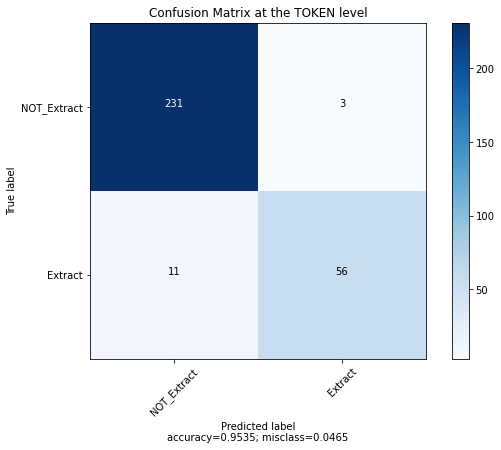

In [31]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['NOT_Extract', 'Extract'],
                      title        = "Confusion Matrix at the TOKEN level")

f1=0.889


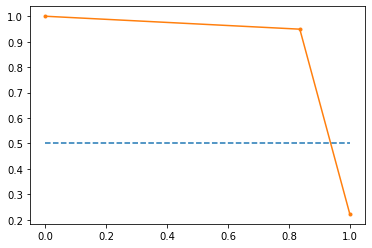

In [32]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
print('f1=%.3f' % (f1))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()